# Minimal character-level Vanilla RNN model.

RNN stand for "Recurent Neural Network".  
To understand why RNN are so hot you _must_ read [this](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)!  

This notebook to explain the _[Minimal character-level Vanilla RNN model](https://gist.github.com/karpathy/d4dee566867f8291f086)_ written by __Andrej Karpathy__  
This code create a RNN to generate a text, char after char, by learning char after char from a textfile.

I love this _character-level Vanilla RNN_ code because it doesn't use any library except numpy.
All the NN magic in 112 lines of code, no need to understand any dependency. Everything is there! I'll try to explain in detail every line of it. Disclamer: I still need to use some external links for reference.  

This notebook is for real beginners who whant to understand RNN concept by reading code.  
Feedback welcome __@dh7net__
 
## Let's start!  
Let's see the original code and the results for the first 1000 iterations.

In [1]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# data I/O
data = open('methamorphosis.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print 'data has %d characters, %d unique.' % (data_size, vocab_size)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in xrange(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(xrange(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in xrange(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while n<=1000: # was while True: in original code
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print '----\n %s \n----' % (txt, )

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print 'iter %d, loss: %f' % (n, smooth_loss) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

data has 119163 characters, 61 unique.
----
 ,JLBhcuSwFdHYCU!i?mFSePjkl)v(t!M.ldrDV-OqSAWx:iBocJGHUUlw b.E i-gtiHnTOabv omHfcmAMw'(i:uo"iQY!."um'GA!W jYANMydLbbu!.a'MUHzxnsJDiAzULI,U!pWT)vaYCQwPx:;ulgoPqGD
mJxivk'alh,LiSJxDgS;r.yGeJnfCmDkD,EWQio 
----
iter 0, loss: 102.771854
----
 O hA  ieeaicmauytaas ovtf seGwayt as,ulf aot'batLbuc L idhassbac dbseoat aic  fp losnhegw ,PcdUcnna co-tW o  oAcMm
t  uyn ao bug dDsmhatqoAtliaseeap'ha.; ec desn eee ss,!ucttoc(a,c aoeelacnorn h.oSblo 
----
iter 100, loss: 102.940407
----
 ln h wsa a
afe vdbee bh tfveioyoloeeltsaliaWrlkadylclnruhpead wa 
i-ditx oab wts
  em.lsoesu t" H d  rsa wst wdteaidthss tsdlushl vinceG)eaeOz eops hieoesf
t ei WiaHb-e
n-slrwsh
sdroe,wedpn neresl rhg 
----
iter 200, loss: 101.077410
----
 Gned -nd  wt wftiwp so LardpfenWimeooWpd
u ieacetH   oponebpGa rgo"femnkoha,
"ie efngnkd fhoie gt eoteh Glt.vQOtueT sl tl  n.hiipge itth e islmktw ow g rhet hauoqun cwkblo rslpuCf shas cTgtoce.l,ts fe 
----
iter 300, loss: 99.188995
----

If you are not a NN expert, the code is not easy to understand.  

If you look to the results you can see that the code iterate 1000 time, calculate a __loss__ that decrease over time, and output some text each 100 iteration.
The output from the first iteration looks random.  
After 1000 iterations, the NN is able to create words that have plausible size, don't use too much caps, and can create correct small words like "the", "they", "be", "to".  
If you let the code learn over a nigth the NN will be able to create almost correct sentences:  
_"with home to get there was much hadinge everything and he could that ho women this tending applear space"_  
This is just a simple exemple, and there is no doubt this code can do much better.

## Theorie
This code build a neural network that is able to predict one char from the previous one.  
In this example, it learn from a text file, so he can learn words and sentence ; if you feed HTML or XML during the tranning it can produce valid HTML or XML sequences.  
At each step it can use some results from the previous step to keep in memory what is going on.  
For instance if the previous char are "hello worl" the model can guess that the next char is "d".

This model contain parameters that are initialized randomly and the trainning phase try to find optimal values for each of them. 
During the trainning process we do a _"gradient descent"_:
* We give to the model a pair of char: the input char and the target char. The target char is the char the network should guess, it is the next char in our trainning text file.
* We calculate the probability for every possible next char according to the state of the model, using the paramters (This is the forward pass).
* We create a distance (the loss) between the previous probabilty and the target char.
* We calculate gradients for each of our parameters to see witch impact they have on the loss. (A fast way to calculate all gradients is called the backward pass).
* We update all parameters in the direction that help to minimise the loss
* We iterate until their is no more progress and print a generated sentence from times to times.

# Let's dive in! 

## The code contains 4 parts
* Load the trainning data
  * encode char into vectors
* Define the Network
* Define a function to create sentences from the model
* Define a loss function
  * Forward pass
  * Loss
  * Backward pass
* Train the network
  * Feed the network
  * Calculate gradiend and update the model parameters
  * Output a text to see the progress of the training
 
Let's have a closer look to every line of the code.  
__Disclaimer:__ the following code is cut and pasted from the original ones, with some adaptation to make it clearer for this notebook, like adding some _print_.

## Load the training data

The network need a big txt file as an input.

The content of the file will be used to train the network.

For this example, I used Methamorphosis from Kafka (Public Domain).

In [2]:
"""                                                                                                                                                                                           
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)                                                                                                             
BSD License                                                                                                                                                                                   
"""
import numpy as np

# data I/O                                                                                                                                                                                    
data = open('methamorphosis.txt', 'r').read() # should be simple plain text file   

### Encode/Decode char/vector
Neural networks can only works on vectors. (a vector is an array of float)
So we need a way to encode and decode a char as a vector.

For this we count the number of unique char (*vocab_size*). It will be the size of the vector. 
The vector contain only zero exept for the position of the char wherae the value is 1.

#### First we calculate *vocab_size*:

In [3]:
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print 'data has %d characters, %d unique.' % (data_size, vocab_size)

data has 119163 characters, 61 unique.


#### Then we create 2 dictionary to encode and decode a char to an int

In [4]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print char_to_ix
print ix_to_char

{'\n': 0, '!': 1, ' ': 2, '"': 3, "'": 4, ')': 5, '(': 6, '-': 7, ',': 8, '.': 9, ';': 10, ':': 11, '?': 12, 'A': 13, 'C': 14, 'B': 15, 'E': 16, 'D': 17, 'G': 18, 'F': 19, 'I': 20, 'H': 21, 'J': 22, 'M': 23, 'L': 24, 'O': 25, 'N': 26, 'Q': 27, 'P': 28, 'S': 29, 'U': 30, 'T': 31, 'W': 32, 'V': 33, 'Y': 34, 'a': 35, 'c': 36, 'b': 37, 'e': 38, 'd': 39, 'g': 40, 'f': 41, 'i': 42, 'h': 43, 'k': 44, 'j': 45, 'm': 46, 'l': 47, 'o': 48, 'n': 49, 'q': 50, 'p': 51, 's': 52, 'r': 53, 'u': 54, 't': 55, 'w': 56, 'v': 57, 'y': 58, 'x': 59, 'z': 60}
{0: '\n', 1: '!', 2: ' ', 3: '"', 4: "'", 5: ')', 6: '(', 7: '-', 8: ',', 9: '.', 10: ';', 11: ':', 12: '?', 13: 'A', 14: 'C', 15: 'B', 16: 'E', 17: 'D', 18: 'G', 19: 'F', 20: 'I', 21: 'H', 22: 'J', 23: 'M', 24: 'L', 25: 'O', 26: 'N', 27: 'Q', 28: 'P', 29: 'S', 30: 'U', 31: 'T', 32: 'W', 33: 'V', 34: 'Y', 35: 'a', 36: 'c', 37: 'b', 38: 'e', 39: 'd', 40: 'g', 41: 'f', 42: 'i', 43: 'h', 44: 'k', 45: 'j', 46: 'm', 47: 'l', 48: 'o', 49: 'n', 50: 'q', 51: 'p',

#### Finaly we create a vector from a char like this:
The dictionary defined above allow us to create a vector of size 61 instead of 256.  
Here and exemple for char 'a'  
The vector contains only zero, except at position char_to_ix['a'] where we put a 1.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


<IPython.core.display.Javascript object>


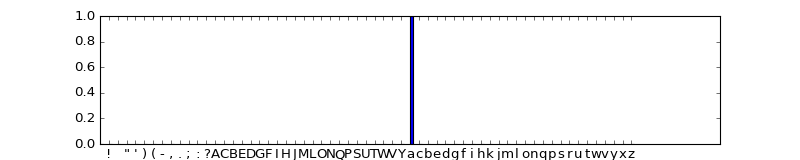

In [17]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

vector_for_char_a = np.zeros((vocab_size, 1))
vector_for_char_a[char_to_ix['a']] = 1
#print vector_for_char_a
print vector_for_char_a.ravel()

x = range(0,len(chars))
plt.figure(figsize=(10,2))
plt.bar(x, vector_for_char_a.ravel(), 0.3)
plt.xticks(x, chars)
plt.show()

## Definition of the network

The neural network is made of 3 layers:
* an input layer
* an hidden layer
* an output layer

All layers are fully connected to the next one: each node of a layer are conected to all nodes of the next layer.
The hidden layer is connected to the output and to itself: the values from an iteration are used for the next one.

To centralise values that matter for the training (_hyper parameters_) we also define the _sequence lenght_ and the _learning rate_

In [6]:
# hyperparameters                                                                                                                                                                             
hidden_size = 100 # size of hidden layer of neurons                                                                                                                                           
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [7]:
# model parameters                                                                                                                                                                            
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
print 'Wxh contain', Wxh.size, 'parameters'
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
print 'Whh contain', Whh.size, 'parameters'
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output    
print 'Why contain', Why.size, 'parameters'
bh = np.zeros((hidden_size, 1)) # hidden bias
print 'bh contain', bh.size, 'parameters'
by = np.zeros((vocab_size, 1)) # output bias
print 'by contain', by.size, 'parameters'

Wxh contain 6100 parameters
Whh contain 10000 parameters
Why contain 6100 parameters
bh contain 100 parameters
by contain 61 parameters


The model parameters are adjusted during the trainning.
* _Wxh_ are parameters to connect a vector that contain one input to the hidden layer.
* _Whh_ are parameters to connect the hidden layer to itself. This is the Key of the Rnn: Recursion is done by injecting the previous values from the output of the hidden state, to itself at the next iteration.
* _Why_ are parameters to connect the hidden layer to the output
* _bh_ contains the hidden bias
* _by_ contains the output bias

You'll see in the next section how theses parameters are used to create a sentence.

## Create a sentence from the model

In [23]:
def sample(h, seed_ix, n):
  """                                                                                                                                                                                         
  sample a sequence of integers from the model                                                                                                                                                
  h is memory state, seed_ix is seed letter for first time step                                                                                                                               
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in xrange(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  txt = ''.join(ix_to_char[ix] for ix in ixes)
  print '----\n %s \n----' % (txt, )

hprev = np.zeros((hidden_size,1)) # reset RNN memory  
sample(hprev,char_to_ix['a'],200)

----
 th there pseblfily to serm havestice."  Gregor with and be not intwing, sisticharry morey morcting enfureathid net it with trom breather he climale would pulling staclime, hadsing, but thears't eraide 
----


## Define the loss function
The __loss__ is a key concept in all neural networks trainning. 
It is a value that describe how bag/good is our model.  
It is always positive, the closest to zero, the better is our model.  
(A good model is a model where the predicted output is close to the training output)
  
During the trainning phase we want to minimize the loss.

The loss function calculate the loss but also the gradients (see backward pass):
* It perform a forward pass: calculate the next char given a char from the trainning set.
* It calculate the loss by comparing the predicted char to the target char. (The target char is the input following char in the tranning set)
* It calculate the backward pass to calculate the gradients (see the backword pass paragraph) 

This function take as input:
* a list of input char
* a list of target char
* and the previous hidden state

This function output:
* the loss
* the gradient for each parameters between layers
* the last hidden state

Here the code:

In [9]:
def lossFun(inputs, targets, hprev):
  """                                                                                                                                                                                         
  inputs,targets are both list of integers.                                                                                                                                                   
  hprev is Hx1 array of initial hidden state                                                                                                                                                  
  returns the loss, gradients on model parameters, and last hidden state                                                                                                                      
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass                                                                                                                                                                              
  for t in xrange(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation                                                                                                                        
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state                                                                                                            
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars                                                                                                           
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars                                                                                                              
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)                                                                                                                       
  # backward pass: compute gradients going backwards                                                                                                                                          
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(xrange(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y                                                                                                                                                     
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h                                                                                                                                         
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity                                                                                                                     
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients                                                                                                                 
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]


### Forward pass
The forward pass use the parameters of the model (Wxh, Whh, Why, bh, by) to calculate the next char given a char from the trainning set.

xs[t] is the vector that encode the char at position t
ps[t] is the probabilities for next char

```python
hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
```

or is dirty pseudo code for each char
```python
hs = input*Wxh + last_value_of_hidden_state*Whh + bh
ys = hs*Why + by
ps = normalized(ys)
```

To dive into the code, we'll work on one char only (we set t=0 ; instead of the "for each" loop).

p(
)= 0.0046 
p(!)= 0.0011  p( )= 0.0443  p(")= 0.0006  p(')= 0.0020  p())= 0.0001  p(()= 0.0000  p(-)= 0.0001 
p(,)= 0.0028  p(.)= 0.0010  p(;)= 0.0019  p(:)= 0.0003  p(?)= 0.0006  p(A)= 0.0000  p(C)= 0.0000 
p(B)= 0.0000  p(E)= 0.0000  p(D)= 0.0000  p(G)= 0.0000  p(F)= 0.0000  p(I)= 0.0000  p(H)= 0.0000 
p(J)= 0.0000  p(M)= 0.0000  p(L)= 0.0000  p(O)= 0.0000  p(N)= 0.0000  p(Q)= 0.0000  p(P)= 0.0000 
p(S)= 0.0000  p(U)= 0.0000  p(T)= 0.0001  p(W)= 0.0000  p(V)= 0.0000  p(Y)= 0.0000  p(a)= 0.0051 
p(c)= 0.0018  p(b)= 0.0002  p(e)= 0.0075  p(d)= 0.1185  p(g)= 0.0011  p(f)= 0.3273  p(i)= 0.0000 
p(h)= 0.0001  p(k)= 0.0002  p(j)= 0.0002  p(m)= 0.0923  p(l)= 0.0028  p(o)= 0.0001  p(n)= 0.0222 
p(q)= 0.0006  p(p)= 0.0051  p(s)= 0.0191  p(r)= 0.0087  p(u)= 0.0000  p(t)= 0.0127  p(w)= 0.0040 
p(v)= 0.3057  p(y)= 0.0001  p(x)= 0.0046  p(z)= 0.0000 

<IPython.core.display.Javascript object>


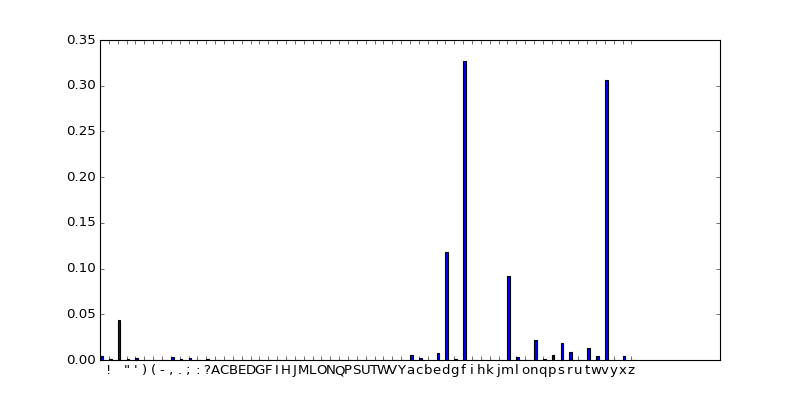

In [24]:
# uncomment the print to get some details
xs, hs, ys, ps = {}, {}, {}, {}
hs[-1] = np.copy(hprev)
# forward pass                                                                                                                                                                              
t=0 # for t in xrange(len(inputs)):
xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
xs[t][inputs[t]] = 1 
# print xs[t]
hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state 
ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
# print ys[t]
ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars  
# print ps[t].ravel()

# Let's build a dict to see witch probablity is associated with witch char
probability_per_char =  { ch:ps[t].ravel()[i] for i,ch in enumerate(chars) }
# uncoment the next line to see the raw result
# print probability_per_char

# To print the probability in a way that is more easy to read.
for x in range(vocab_size):
    print 'p('+ ix_to_char[x] + ")=", "%.4f" % ps[t].ravel()[x],
    if (x%7==0):
        print ""
    else:
        print "",

x = range(0,len(chars))
plt.figure(figsize=(10,5))
plt.bar(x, ps[t], 0.3)
plt.xticks(x, chars)
plt.show()

In [11]:
# We can create the next char from the above distribution
ix = np.random.choice(range(vocab_size), p=ps[t].ravel())
print
print "Next char code is:", ix
print "Next char is:", ix_to_char[ix]


Next char code is: 41
Next char is: f


You can run the previous code several time. A char is generated for a given probability.

### Loss
For each char in the input the forward pass calculate the probability of the next char  
The loss is the sum 
```python
loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
```

The loss is calculate using Softmax. [more info here](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/) and [here](https://en.wikipedia.org/wiki/Softmax_function).


In [12]:
print 'Next char from training (target) was number', targets[t], 'witch is "' + ix_to_char[targets[t]] + '"'
print 'Probability for this letter was', ps[t][targets[t],0]

loss = -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
print 'loss for this input&target pair is', loss

Next char from training (target) was number 36 witch is "c"
Probability for this letter was 0.016374230879
loss for this input&target pair is 4.11204646779


### Backward pass

The goal of the backward pass is to calculate all gradients.  
Gradients tell in witch direction you have to move your parameter to make a better model.

The naive way to calculate all gradients would be to recalculate a loss for small variations for each parameters.
This is possible but would be time consuming. We have more than 20k parameters.
There is a technic to calculates all the gradients for all the parameters at once: the backdrop propagation.  
Gradients are calculated in the oposite order of the forward pass, using simple technics.  

For instance if we have:  

```python
loss = a.x + b  
```
If we want to minimize _loss_, we need to calculate d(loss)/dx and use it to calculate the new_x value.  
```python
new_x = x - d(loss)/dx * step_size
```
If new_loss is smaller than loss, it is a win: we succeed to find a better x input.  

Lets do the math:  
d(loss)/dx = d(a.x)/dx +d(b)/dx  
d(loss)/dx = (d(a)/dx)*1 + a*d(x)/dx + 0  
d(loss)/dx = 0 + a*1  
d(loss)/dx = a  

In [13]:
x = 10  
a = 3  
b = 7

loss = a+x + b
print 'initial loss =', loss
# dx stand for d(loss)/dx
dx = a #Calculate dx=d(loss)/dx analytically
step_size = 0.1
# use dx and step size to calculate new x
new_x = x - dx * step_size
new_loss = a+new_x + b
print 'new loss =',new_loss
if (new_loss<loss): print 'New loss is smaller, Yeah!'

initial loss = 20
new loss = 19.7
New loss is smaller, Yeah!


 

#### goal is to calculate gradients for the forward formula:
```python
hs = input*Wxh + last_value_of_hidden_state*Whh + bh  
ys = hs*Why + by
```

This part need more work to explain the code, but __[here](http://karpathy.github.io/neuralnets/) a great source to understand this technic in detail.__

```python
# Backdrop this: ys = hs*Why + by
dy=-1 # because the smaller the loss, the better is the model.
dWhy = np.dot(dy, hs.T)
dby = dy
dh = np.dot(Why.T, dy) + dhnext # backprop into h  

dhraw = (1 - hs * hs) * dh # backprop through tanh nonlinearity 

# Backdrop this: hs = input*Wxh + last_value_of_hidden_state*Whh + bh 
dbh += dhraw
dWxh += np.dot(dhraw, xs.T)
dWhh += np.dot(dhraw, hs.T)
dhnext = np.dot(Whh.T, dhraw)
```

In [14]:
# backward pass: compute gradients going backwards                                                                                                                                          
dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
dbh, dby = np.zeros_like(bh), np.zeros_like(by)
dhnext = np.zeros_like(hs[0])
t=0 #for t in reversed(xrange(len(inputs))):
dy = np.copy(ps[t])
dy[targets[t]] -= 1 # backprop into y   
#print dy.ravel()
dWhy += np.dot(dy, hs[t].T)
#print dWhy.ravel()
dby += dy
#print dby.ravel()
dh = np.dot(Why.T, dy) + dhnext # backprop into h                                                                                                                                         
dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity                                                                                                                     
dbh += dhraw
dWxh += np.dot(dhraw, xs[t].T)
dWhh += np.dot(dhraw, hs[t-1].T)
dhnext = np.dot(Whh.T, dhraw)
for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
  np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  #print dparam


## Training

This last part of the code is the main trainning loop:
* Feed the network with portion of the file. Size of cunck is *seq_lengh*
* Use the loss function to:
  * Do forward pass to calculate all parameters for the model for a given input/output pairs
  * Do backward pass to calculate all gradiens
* Print a sentence from a random seed using the parameters of the network
* Update the model using the Adaptative Gradien technique Adagrad

### Feed the loss function with inputs and targets

We create two array of char from the data file,
the targets one is shifted compare to the inputs one.

For each char in the input array, the target array give the char that follows.

In [15]:
p=0  
inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
print "inputs", inputs
targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
print "targets", targets

inputs [25, 49, 38, 2, 46, 48, 53, 49, 42, 49, 40, 8, 2, 56, 43, 38, 49, 2, 18, 53, 38, 40, 48, 53, 2]
targets [49, 38, 2, 46, 48, 53, 49, 42, 49, 40, 8, 2, 56, 43, 38, 49, 2, 18, 53, 38, 40, 48, 53, 2, 29]


### Adagrad to update the parameters

The easiest technics to update the parmeters of the model is this:

```python
param += dparam * step_size
```
Adagrad is a more efficient technique where the step_size are getting smaller during the training.

It use a memory variable that grow over time:
```python
mem += dparam * dparam
```
and use it to calculate the step_size:
```python
step_size = 1./np.sqrt(mem + 1e-8)
```
In short:
```python
mem += dparam * dparam
param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update 
```

### Smooth_loss

Smooth_loss doesn't play any role in the training.
It is just a low pass filtered version of the loss:
```python
smooth_loss = smooth_loss * 0.999 + loss * 0.001
```

It is a way to average the loss on over the last iterations to better track the progress


### So finally
Here the code of the main loop that does both trainning and generating text from times to times:

In [16]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad                                                                                                                
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0                                                                                                                        
while n<=1000*100:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  # check "How to feed the loss function to see how this part works
  if p+seq_length+1 >= len(data) or n == 0:
    hprev = np.zeros((hidden_size,1)) # reset RNN memory                                                                                                                                      
    p = 0 # go from start of data                                                                                                                                                             
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # forward seq_length characters through the net and fetch gradient                                                                                                                          
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001

  # sample from the model now and then                                                                                                                                                        
  if n % 1000 == 0:
    print 'iter %d, loss: %f' % (n, smooth_loss) # print progress
    sample(hprev, inputs[0], 200)

  # perform parameter update with Adagrad                                                                                                                                                     
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                [dWxh, dWhh, dWhy, dbh, dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update                                                                                                                   

  p += seq_length # move data pointer                                                                                                                                                         
  n += 1 # iteration counter            

iter 0, loss: 102.771859
----
 iOaGkb;?nUkdb(wAW :,a.ztetLhS:VNBzJE'mWDtLSU(?mrh'kEtlMPInjI
ae?oINmD'mWhpA"nuSf? sw;)QkOJgtFyvYgUdu:Ug-bC;L'sdd;M().,xiGrxVWqwb,H("bDdyyICCc)aCgNHgTzrrmGutrEBW
)m-?SgE,yPglzt))YfS,ll)Bc":
owsBJCqwNNB 
----
iter 1000, loss: 84.873661
----
  hee hsl, Hpooep, arr gethefy c lhor bomins ;l ithed ha, olebhe tas ncuf hershe chore ef heg tmrec
anonvm, gon tad ghe tipert apsr e.. wat the strent o. ce nn thet  hetifit, t sos, hetiu inhunrneo, wh 
----
iter 2000, loss: 70.122666
----
   finulvet hooncely coolta Wwa thein t hat mout on atkar, apt nwer so hod moosey thabd. whiuc authiut camoachaky, mom -han
tom wwosle mine too
wous rowol. forimeid aoumt ondlif - hheg
s of mabvaut ahi 
----
iter 3000, loss: 62.053303
----
 e lallen the Gicede nfar heath,
anpet
mite repurlraling
cur, ent
th des wrow fald fis sedey
stmint ite whal Gre ccounir, ingmand an hiyis ditd ang hecy, ,ot. to fashasbe
I ank ftane on t his Ob th ,,  
----
iter 4000, loss: 57.657486
----
 ulles owa

Feedback welcome __@dh7net__!